# Regression

## 1. Introduction

We use the [Gas Turbine Dataset](https://archive.ics.uci.edu/ml/datasets/Gas+Turbine+CO+and+NOx+Emission+Data+Set#) for this task: similar to the paper, 2011, 2012 and 2013 are used as training datasets, and 2014/2015 are used for prediction. We have to predict two target variables: CO and NOX, and output them in a CSV file with the columns SNO,CO,NOX.

## 2. Baseline predictions

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
df = pd.read_csv("data/gas_emission/train.csv").set_index('SNO')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22191 entries, 0 to 22190
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      22191 non-null  float64
 1   AP      22191 non-null  float64
 2   AH      22191 non-null  float64
 3   AFDP    22191 non-null  float64
 4   GTEP    22191 non-null  float64
 5   TIT     22191 non-null  float64
 6   TAT     22191 non-null  float64
 7   TEY     22191 non-null  float64
 8   CDP     22191 non-null  float64
 9   CO      22191 non-null  float64
 10  NOX     22191 non-null  float64
dtypes: float64(11)
memory usage: 2.0 MB


A nice reason to choose this dataset: imputation is none of our business. All clean, nice, non-null values.

We'll use Kernel Density Estimation for a baseline: basically, generate a PDF that looks like the distribution of data, and then generate data randomly from that distribution. We're assuming CO and NOX are not correlated (and it doesn't look like it as well

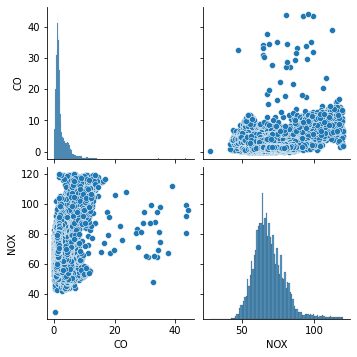

In [94]:
sns.pairplot(df[['CO','NOX']])

In [95]:
from sklearn.neighbors import KernelDensity

test_df = pd.read_csv("data/gas_emission/test.csv").set_index('SNO')

co_kde = KernelDensity(kernel='tophat', bandwidth=0.5).fit(df['CO'].to_numpy().reshape(-1,1))
co_preds = co_kde.sample(len(test_df))
nox_kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(df['NOX'].to_numpy().reshape(-1,1))
nox_preds = nox_kde.sample(len(test_df))

out_df = pd.DataFrame({'CO': np.squeeze(co_preds), 'NOX': np.squeeze(nox_preds)}, index=test_df.index)
out_df.to_csv('baseline_predictions.csv')

In [96]:
import evaluator
evaluator.evaluate_numeric('baseline_predictions.csv', 'data/gas_emission/test_results.csv')

RMSE:
CO      1.961777
NOX    13.828498
dtype: float64


Cool, we have a baseline value that we can aim for now.

## 3. Linear Regression

### 3.1: Normal Form

The normal form equations use the moore-penrose pseudoinverse of the design matrix (Bishop)
$$\begin{align}
\mathbf{w} = (\Phi^T \Phi)^{-1} \Phi^T \textbf{t}
\end{align}
$$

Our design matrix here is going to be the matrix of transformations applied to datapoints in x (for now, it's identity for each index, and 1 for $\phi_0(x)$ to add the regression constant), and t is the set of targets corresponding to each explanatory variable.

In [116]:
from sklearn.base import BaseEstimator, TransformerMixin

class NormalLinearRegressor(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.w = None
        self.residuals = None
    
    def fit(self,X,t=None):
        phi = X.drop(['CO','NOX'], axis=1).to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        self.w = np.linalg.inv(phi.T@phi)@phi.T@t
        
        self.residuals = t - self.predict(X.drop(['CO','NOX'], axis=1))
        return self
        
    def predict(self,X):
        phi = X.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        preds = self.w.T@phi.T
        return preds

In [117]:
normal_regr = NormalLinearRegressor().fit(df,t=df['CO'])
preds_CO = normal_regr.predict(test_df)
res_CO = normal_regr.residuals.copy()
normal_regr.fit(df,t=df['NOX'])
preds_NOX = normal_regr.predict(test_df)
res_NOX = normal_regr.residuals.copy()

out = pd.DataFrame({'CO': preds_CO, 'NOX': preds_NOX}, index=test_df.index)
out.to_csv(f"normal_regression_predictions.csv")

In [118]:
evaluator.evaluate_numeric('normal_regression_predictions.csv', 'data/gas_emission/test_results.csv')

RMSE:
CO     1.321970
NOX    8.242453
dtype: float64


Nice! Clearly better than random guessing.

### 3.2: Assumptions of the Regression Model

The _residual_ is the difference between any datapoint and the regression plane fitted by the model.

1. **Linearity**: The relationship between X and the mean of Y is linear. An easy way of checking this for univariate regression is to simply plot X versus Y, but for multivariate regression, we use a scatter plot of residual versus predicted value: a _horizontal band of points_ indicates a linear relationship.
2. **Homoscedasticity**: The variance of the residual is the same for any value of X. A scatter plot of residuals versus fitted values should suffice for this.
3. **Independence**: Observations are independent of each other. Use the same plot as above.
4. **Normality of Errors**: The residuals must be normally ditributed (we use this assumption in the LL-derivation of the normal equations). A QQ (Quantile-Quantile) plot of the normal distribution v/s the residual distribution is plotted and the fit is observed.

For a good regression fit, we'll need to check each of these assumptions

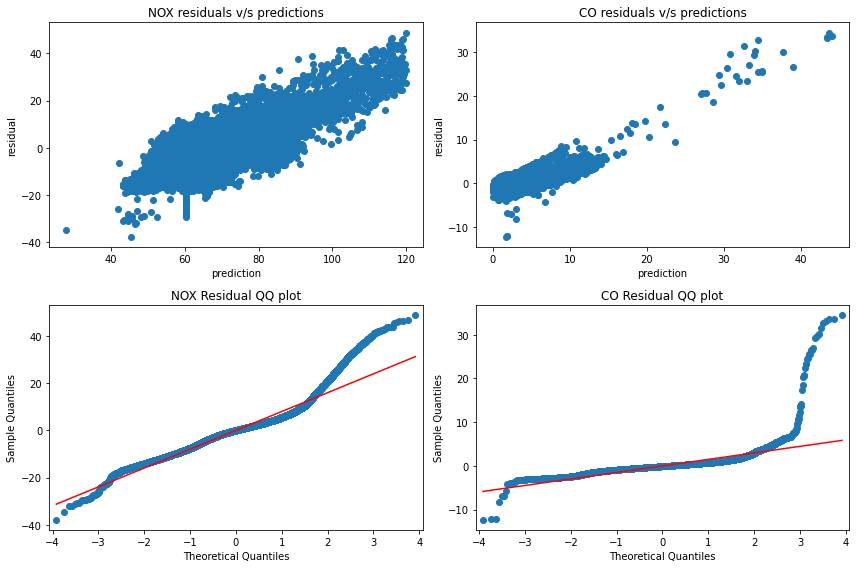

In [137]:
import statsmodels.api as sm


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0,0].scatter(x=df['NOX'],y=res_NOX)
axs[0,0].set_title('NOX residuals v/s predictions')
axs[0,0].set_xlabel('prediction')
axs[0,0].set_ylabel('residual')

axs[0,1].scatter(x=df['CO'],y=res_CO)
axs[0,1].set_title('CO residuals v/s predictions')
axs[0,1].set_xlabel('prediction')
axs[0,1].set_ylabel('residual')

sm.qqplot(res_NOX, ax=axs[1,0], line='s', markerfacecolor='C0', markeredgecolor='C0')
axs[1,0].set_title('NOX Residual QQ plot')

sm.qqplot(res_CO, ax=axs[1,1], line='s', markerfacecolor='C0', markeredgecolor='C0')
axs[1,1].set_title('CO Residual QQ plot')

plt.tight_layout()
plt.show()

Ouch! These are suboptimal. There's clearly heteroscedasticity, nonlinearity and everything else. We'll need to do a bit of feature engineering to make the fit better, but before that:

### 3.3: Goodness of Fit

The $R^2$ statistic measures the goodness of fit: how well the linear regression model explains the data. 

$$\begin{align}
R^2 &= 1 - \frac{SS_{res}}{SS_{tot}} \\
\text{where } SS_{res} &= \sum_i e_i^2 \\
SS_{tot} &= \sum_{i} (y_i - \overline{y})^2
\end{align}$$

In [138]:
r_sq_nox = 1 - res_NOX.pow(2).sum()/(df['NOX'] - df['NOX'].mean()).pow(2).sum()
r_sq_co = 1 - res_CO.pow(2).sum()/(df['CO'] - df['CO'].mean()).pow(2).sum()

print(f"r_sq_nox: {r_sq_nox}")
print(f"r_sq_co: {r_sq_co}")

r_sq_nox: 0.47818394729115155
r_sq_co: 0.5783710093608008


$R^2$ should be >0.7 for an explainable model and >0.8 for a good one :(

## 4. Feature Engineering

In [ ]:
# TODO examine and engineer features